# Lecture 3 - HJB Equations

This follows the lecture notes produced by Ben Moll. Particularly the [third lecture](https://benjaminmoll.com/wp-content/uploads/2019/07/Lecture3_2149.pdf) under "Distributional Macroeconomcis".

The HJB for a neoclassical growth model can be represented as:

$$
\rho v(k) = \max_c u(c) + v'(k)(F(k) - \delta k - c)
$$

We use functional forms $F(k) = k^\alpha$ and $u(c) = \frac{c^{- \sigma}}{1 - \sigma}$

# Finite Differences

Approximate $v(k)$ at $I$ discrete points in the state space $k$. We get $k_i$ for $i = 1, 2, 3... I$. Distance between two points is $\Delta k$

Short hand notation: $v_i = v(k_i)$

The finite difference version of the HJB is:

$$
\rho v_i = \max_c u(c_i) + v'_i (F(k_i) - \delta k_i - c_i)
$$

Where $c_i = (u')^{-1}(v_i)$.

$v'_i$ is one of backward, forward or central FD approximations.

$$
v'_i \approx \frac{v_i - v_{i-1}}{\Delta k} = v'_{i, B} \tag{backward}
$$

$$
v'_i \approx \frac{v_{i+1} - v}{\Delta k} = v'_{i, F} \tag{forward}
$$

$$
v'_i \approx \frac{v_{i+1} - v_{i-1}}{2 \Delta k} = v'_{i, C} \tag{central}
$$

In [1]:
] activate .

 Activating environment at `C:\Users\Hariharan\Documents\git_repos\ben_moll_lecture_code\Project.toml`


In [2]:
using LinearAlgebra, Parameters, Plots

In [35]:
# Storing parameters
opgrowth = @with_kw (α = 0.3, 
    A = 1, σ = 2, ρ = 0.05, 
    δ = 0.05, I = 150)

function u(c, σ = 2.0)
    # CRRA utility
   
    if σ == zero(σ)
        u = log.(c)
    else
        u = (c.^(1 - σ))/(1 - σ)
    end
    
    return u
end

function udash_inv(x, σ = 2.0)
    # Inverse of the derivative
    # of CRRA
    
    udash_inv = x.^(-1/σ)
    
    return udash_inv
end

# Some nice formulas based on parameters
F(k, α = 0.3, A = 1.0) = A.*k.^α
Fdash(k, α = 0.3, A = 1.0) = A * α .* k .^ (α - 1)
kstar(α = 0.3, A = 1.0, ρ = 0.05, δ = 0.05) = (α * A/(ρ + δ))^(1/(1-α))
cstar(α = 0.3, A = 1.0, ρ = 0.05, δ = 0.05) = F(kstar(α, A, ρ, δ), α, A) - δ * kstar(α, A, ρ, δ)

# create kgrid
kmin = 0.001*kstar()
kmax = 2*kstar()
k = range(kmin, kmax, length = 150) |> collect;

In [234]:
# Defining forward and backward difference functions
function fdiff(x, dx)
    #==
    Forward difference
    x is an array
    ==#
    
    # initialize array
    fdiffx = zero(x)
    fdiffx[1:end-1] = (x[2:end] - x[1:end - 1])/dx
    
    return fdiffx
end

function bdiff(x, dx)
    #==
    Backward difference
    x is an array
    ==#
    
    # initialize array
    bdiffx = zero(x)
    bdiffx[2:end] = (x[2:end] - x[1:end - 1])/dx
    
    return bdiffx
end

bdiff (generic function with 2 methods)

# Iterative Method / Value Function Iteration

As per the lecture slides, we first go over solving the problem with the "explicit" iteration method. It looks very similar to the simple value function iteration method one does when solving dynamic programming problems in discrete time.

Update $v^n$ to $v^{n+1}$ according to:
$$
\frac{}{}
$$

In [222]:
function viter(params, vupdate_rule; maxiter = 1000, tol = 1e-6)
    
    #==
    Solves the HJB equation. Can specify how to update
    the value function via vupdate_rule.
    vupdate_rule has to have 3 possible arguments :
    v, kgrid, and params
    ==#
    
    @unpack α, A, σ, ρ, δ, I = params
    
    # get k grid
    kmin = 0.001*kstar()
    kmax = 2*kstar()
    kgrid = range(kmin, kmax, length = I) |> collect
    
    # Preallocate k
    kseries = zeros(I)
    cseries = zeros(I)
    
    # initial guess
    v0 = u(kgrid)
    
    # iterate    
    error = 1.0
    iter = 1
    
    while error > tol && iter < maxiter
        vout, verror, k, c = vupdate_rule(v0, kgrid, params)
        
        kseries = k
        cseries = c
        error = maximum(abs.(verror))
        
        v0 = vout
        iter += 1
    end
    
    # Output Message
    if iter == maxiter
        println("==========================", "\n",
                "Convergence failed. Max iterations of $maxiter reached", "\n",
                "Error: $error", "\n",
                "==========================")
    else
        println("==========================", "\n",
                "Convergence Successful!", "\n",
                "Error: $error", "\n",
                "Iterations: $iter", "\n",
                "==========================")
    end
    
    return v0, error, kseries, cseries
    
end

viter (generic function with 3 methods)

In [235]:
function explicit_update(v, k, params)
    #==
    Updates the value function by one step
    in the explicit method
    ==#
    
    @unpack α, A, σ, ρ, δ, I = params
    
    dk = (k[end] - k[1])/(I-1)
    
    vfdiff = fdiff(v, dk)
    vbdiff = bdiff(v, dk)
    
    # cant be negative
    vfdiff[vfdiff .< 0.0] .= 1e-6
    vbdiff[vbdiff .< 0.0] .= 1e-6
    
    cf = udash_inv(vfdiff, σ)
    cb = udash_inv(vbdiff, σ)
    
    sf = F(k, α, A) - δ .* k - cf
    sb = F(k, α, A) - δ .* k - cb
    
    ssarr = F(k, α, A) - δ .* k
    ssarr[ssarr .< 0.0] .= 1e-6
    vdiff_ss = udash_inv(ssarr, σ)
    
    # constructing indicators for drift
    If = sf .> 0.0
    Ib = sb .< 0.0
    
    # at the boundries
    Ib[1] = 0.0
    If[1] = 1.0
    Ib[I] = 1.0
    If[I] = 0.0
    
    # SS indicator
    I0 = 1.0 .- If - Ib
    
    # upwind
    dv = vfdiff.*If + vbdiff.*Ib + vdiff_ss.*I0
    
    # dv should never be negative
    dv[dv .< 0.0] .= 1e-6
    
    c = udash_inv(dv, σ)
    
    # Constructing A matrix
    
    

    return vout, vchange, k, c
    
end

vupdate (generic function with 1 method)

In [236]:
og = opgrowth()
vout, error, kseries, cseries = viter(og, explicit_update, maxiter=10000)

Convergence Successful!
Error: 9.982913165007545e-7
Iterations: 6942


([-28.034336187601124, -22.61016826569204, -21.666271884037048, -21.069127856167416, -20.617930836189764, -20.249919847578397, -19.936555339764894, -19.662216625603225, -19.41733223397823, -19.195570750625723  …  -12.942996534167273, -12.924359355160114, -12.905836438851235, -12.887426625974147, -12.86912876595495, -12.850941717415916, -12.832864348618584, -12.814895537851642, -12.797034173768472, -12.779279155678754], 9.982913165007545e-7, [0.0048039866566730914, 0.06925478750693825, 0.13370558835720342, 0.1981563892074686, 0.26260719005773375, 0.3270579909079989, 0.3915087917582641, 0.45595959260852925, 0.5204103934587944, 0.5848611943090596  …  9.027916105693796, 9.092366906544061, 9.156817707394326, 9.221268508244592, 9.285719309094857, 9.350170109945122, 9.414620910795387, 9.479071711645652, 9.543522512495917, 9.607973313346182], [0.10900529537776069, 0.26130757430965396, 0.32852968137001026, 0.3779471264965678, 0.41848872895258965, 0.45351249396306814, 0.4846973102788665, 0.51301

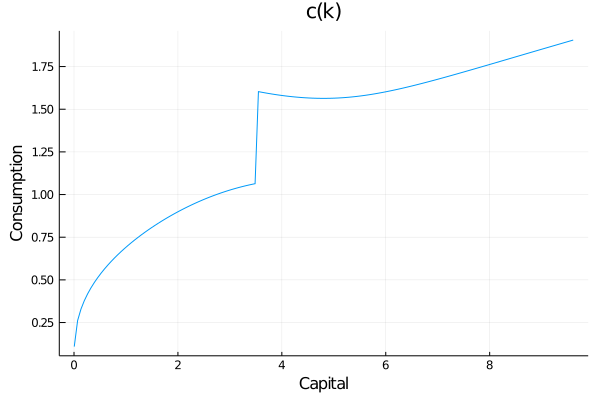

In [246]:
plot(kseries, cseries, label = "", 
    xlabel = "Capital", ylabel = "Consumption", 
    title = "c(k)")

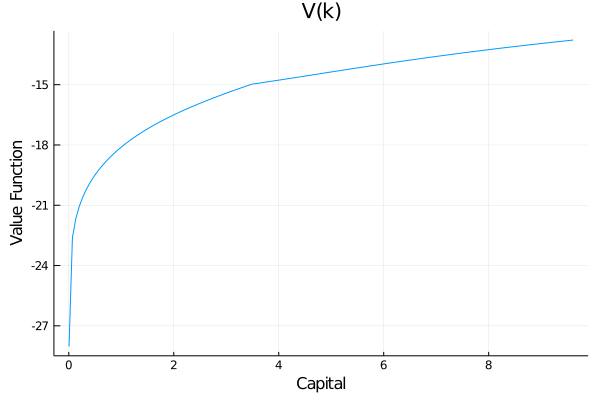

In [247]:
plot(kseries, vout, label = "", 
    xlabel = "Capital", ylabel = "Value Function", 
    title = "V(k)")

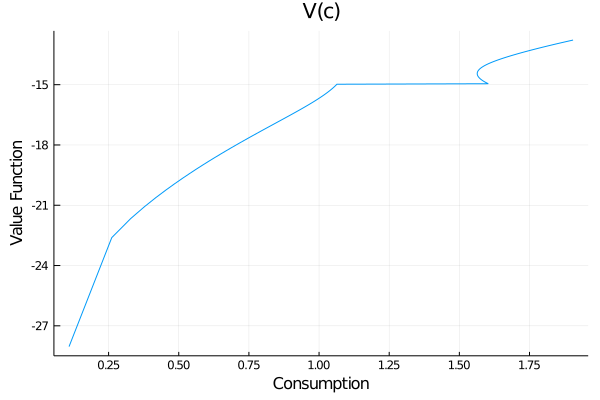

In [242]:
plot(cseries, vout, label = "", 
    xlabel = "Consumption", ylabel = "Value Function", 
    title = "V(c)")

As the lecture slides warn, this takes a long time to converge! 

So we should give the implicit method a shot.

In [ ]:
function implicit_solver(v, k, params)
    #==
    Implicit solution method
    ==#
    
    @unpack α, A, σ, ρ, δ, I = params
    
    dk = (k[end] - k[1])/(I-1)
    
    vfdiff = fdiff(v, dk)
    vbdiff = bdiff(v, dk)
    
    # cant be negative
    vfdiff[vfdiff .< 0.0] .= 1e-6
    vbdiff[vbdiff .< 0.0] .= 1e-6
    
    cf = udash_inv(vfdiff, σ)
    cb = udash_inv(vbdiff, σ)
    
    sf = F(k, α, A) - δ .* k - cf
    sb = F(k, α, A) - δ .* k - cb
    
    ssarr = F(k, α, A) - δ .* k
    ssarr[ssarr .< 0.0] .= 1e-6
    vdiff_ss = udash_inv(ssarr, σ)
    
    # constructing indicators for drift
    If = sf .> 0
    Ib = sb .< 0
    
    # at the boundries
    Ib[1] = 0.0
    If[1] = 1.0
    Ib[I] = 1.0
    If[I] = 0.0
    
    # SS indicator
    I0 = 1.0 .- If - Ib
    
    # upwind
    dv = vfdiff.*If + vbdiff.*Ib + vdiff_ss.*I0
    
    # dv should never be negative
    dv[dv .< 0.0] .= 1e-6
    
    c = udash_inv(dv, σ)
    
    # updating
    vchange = u(c, σ) + dv .* (F(k, α, A) - δ .* k  - c) - ρ .* v
    
    # the following CFL condition seems to work well in practice
    # shamelessly copied from Ben Moll's code
    dk = (k[end] - k[1])/(I-1)
    Δv = .9*dk/maximum(F(k, α, A) - δ.*k);
    vout = v + Δv*vchange
    

    return vout, vchange, k, c
    
    
end